In [ ]:
import pandas as pd
import numpy as np
import requests

## Prepare repo list for further processing

In [ ]:
df = pd.read_excel("repo-candidates/combined.xlsx")

# remove less useful fields, serve as main record
df.to_csv(
    "repo-candidates/main.csv",
    index=False,
    columns=[
        "id", "full_name", "topics", "default_branch",
        "homepage", "description", "fork", "language",
        "license", "pushed_at", "created_at",
        "updated_at", "size", "forks_count", "stargazers_count",
        "watchers_count", "open_issues_count", "has_discussions",
        "has_downloads", "has_issues", "has_pages", "has_projects",
        "has_wiki", "is_template", "web_commit_signoff_required",
    ]
)

# slim version for collecting go.mod files on cloud
df.to_csv(
    "repo-candidates/slim.csv",
    columns=[
        'id', 'full_name', 'stargazers_count',
        'forks_count', 'created_at'
    ]
)

In [ ]:
df_main = pd.read_csv(
    "repo-candidates/main.csv",
    parse_dates=[ "pushed_at", "created_at", "updated_at" ]
)

In [133]:
df_top = df_main[["full_name", "forks_count", "stargazers_count", "watchers_count", "open_issues_count", "created_at"]].sort_values("stargazers_count", ascending=False)
df_top['since'] = df_top['created_at'].dt.year
df_top['month'] = df_top['created_at'].dt.month
df_top = df_top.drop(columns=["created_at"])

In [ ]:
df_monthly = df_top.groupby(["since", "month"]).agg(new_projects=pd.NamedAgg(column="full_name", aggfunc="count"))
#df_vis1 = df_monthly.unstack(level=1).fillna(0).astype("int32")
#df_vis1.reset_index(level=0, inplace=True)
df_monthly.reset_index(level=1, inplace=True)
df_monthly.reset_index(level=0, inplace=True)
df_vis1 = df_monthly
df_vis1
# df_vis1.plot(x='since', kind='bar', stacked=True, title='New projects by month since 2008')

In [168]:
df_vis1

,since,month,new_projects
0,2008,5,1
1,2008,9,1
2,2008,10,1
3,2009,2,1
4,2009,7,1
...,...,...,...
166,2023,4,353
167,2023,5,288
168,2023,6,230
169,2023,7,175


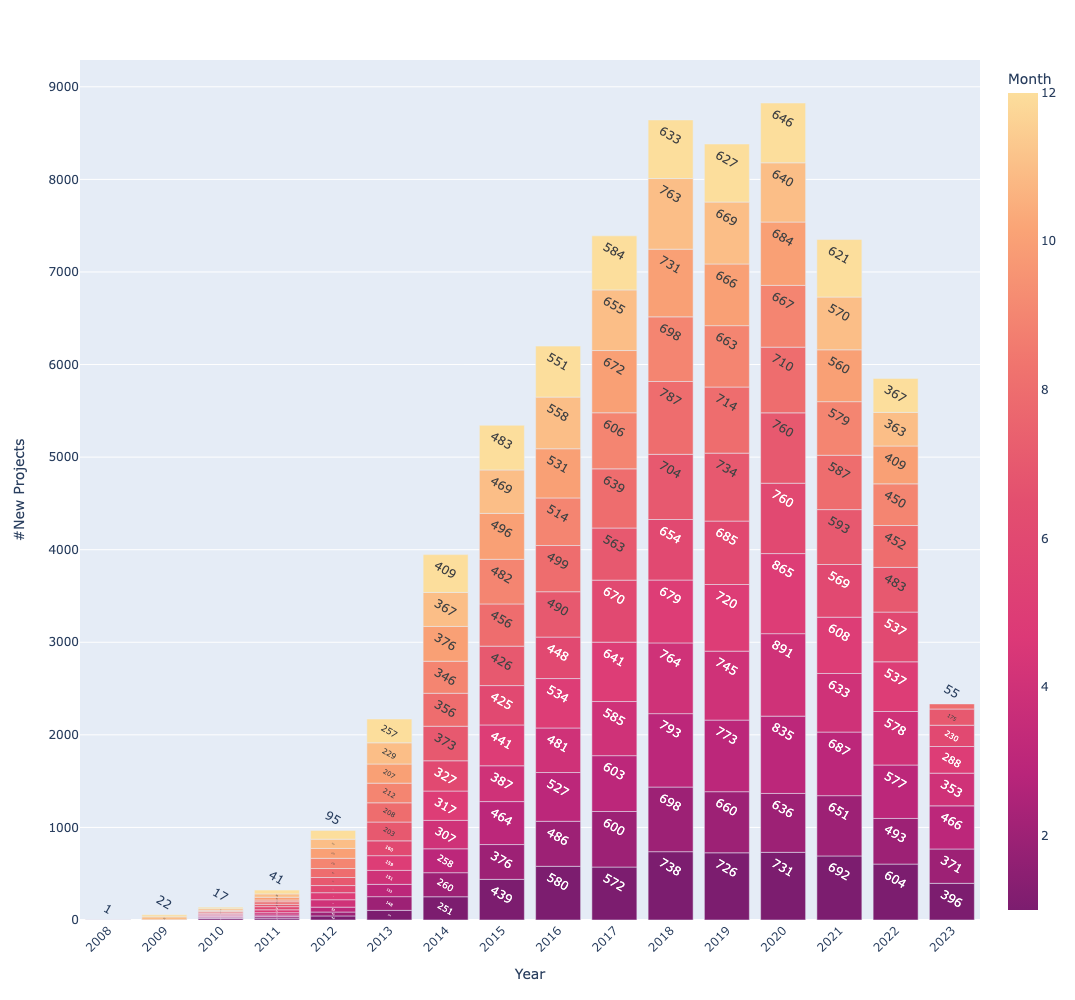

In [195]:
import plotly.express as px
fig = px.bar(df_vis1, x="since", y="new_projects",
             color_continuous_scale=px.colors.sequential.Sunsetdark_r,
             color='month', barmode='stack', text="new_projects",
             labels={
                 "since": "Year",
                 "new_projects": "#New Projects",
                 "month": "Month",
             },
             height=1000)
fig.update_traces(textfont_size=12, textangle=30, cliponaxis=False)
fig.update_layout(xaxis={"dtick":1, "tickangle":-45})


fig.show()

In [ ]:
df_top20 = df_top.head(20)
df_top20.rename(columns={"full_name": "repository", "forks_count": "forks", "stargazers_count": "stars", "watchers_count": "watchers", "open_issues_count": "issues"}, inplace=True)
df_top20
df_top20.to_latex("__tab1.tex", index=False)

In [118]:
stats = df_main.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])
stats = stats.astype('int32').drop(columns=["id"])
stats.rename(columns={"forks_count": "forks", "stargazers_count": "stars", "watchers_count": "watchers", "open_issues_count": "issues"}, inplace=True)
stats.to_latex("__tab1.tex", index=False)

In [119]:
stats

,size,forks,stars,watchers,issues
count,67923,67923,67923,67923,67923
mean,11216,42,258,258,9
std,98398,317,1667,1667,76
min,0,0,10,10,0
25%,62,3,15,15,0
50%,321,7,29,29,1
75%,3644,20,85,85,5
95%,42106,128,762,762,34
99%,170481,585,4567,4567,136
max,14983449,38999,113739,113739,8643


## Collect go.mod files(run on cloud) 

## Download go.mod files and extract to mod-info dir

In [ ]:
!scp data-science-station:/home/ubuntu/projects/big-data-task/play-data-science/msr-golang/mod-info.tgz .

In [ ]:
!rm -fr tmp1
!mkdir -p tmp1
!tar -xzf mod-info.tgz -C tmp1

## Parse go.mod files to get module reference count

In [ ]:
%%time
# call the script `parse-module-deps.py`
from parser import parse_deps

parse_deps(base_dir="mod-info.oci", deps_file="dependencies.csv", trace=False)

## Generate module refs (group by dep_module)

In [77]:
df_deps = pd.read_csv('mod-info.oci/dependencies.csv')
df_mod_refs = df_deps.groupby("dep_module").agg(
    refs=pd.NamedAgg(column="full_name", aggfunc="count"),
).sort_values("refs", ascending=False).reset_index()
df_vers = df_deps.groupby(["dep_module", "dep_version"]).agg(refs=pd.NamedAgg(column="full_name", aggfunc="count"))
df_vers.reset_index(level=1, inplace=True)
df_vers.reset_index(level=0, inplace=True)
# get most referenced version
df_mod_refs = df_vers.sort_values("refs").drop_duplicates(["dep_module"], keep="last")
df_mod_refs.rename(columns={'dep_module': 'module', 'dep_version': 'freq_ver'}, inplace=True)

In [78]:
df_name_conv = df_mod_refs.query("module.str.startswith('github.com') == False")
df_name_conv.to_csv("name-conv-module-refs.csv", index=False)

## Associate non-github named modules with their github name

In [ ]:
%%time
# call the script `convert-names.py`
from datagrab.repo import convert_names

convert_names("name-conv-module-refs.csv", progress_file="name-conv-progress.csv", trace=False)


## Join the main record with module ref count

In [82]:
def copy_github_column(row):
    if row['github_name'] != row['github_name'] or row['github_name'] == '-':
        return row['module']
    else:
        return row['github_name']
        
def strip_github_prefix(row):
    return row["github_name"][len("github.com/"):]

    
# merge main record with module ref count
df_name_mapping = pd.read_csv("name-conv-progress.csv", parse_dates=['last_updated'])
df_progress = pd.read_csv("mod-info.oci/progress.csv", parse_dates=["last_updated"])

#df_1 = df_mod_refs.merge(df_name_mapping, how="left", on="module", right_index=False)
df_1 = df_mod_refs.merge(df_name_mapping, how="left", on="module").drop(columns=['last_updated'])
df_1['github_name'] = df_1.apply(copy_github_column, axis=1)
# merge references to same library using different names
df_2 = df_1.groupby(["github_name", "freq_ver"]).agg(
    refs=pd.NamedAgg(column="refs", aggfunc="sum"),
).sort_values("refs", ascending=False)
df_2.reset_index(level=1, inplace=True)
df_2.reset_index(level=0, inplace=True)
df_gh = df_1.query("github_name.str.startswith('github.com')")
df_gh['full_name'] = df_gh.apply(strip_github_prefix, axis=1)
df_gh = df_gh.merge(df_progress, how="left", on="full_name").drop(columns=['last_updated', 'fail_reason'])
df_gh.rename(columns={'module': 'alt'}, inplace=True)
#df_gh = df_gh.merge(df_name_mapping, how="left", on="github_name").drop(columns=['last_updated', 'fail_reason'])

df_final = df_main.merge(df_gh, how="left", on="full_name").drop(columns=["github_name"])
df_final.sort_values("refs", ascending=False, inplace=True)
df_final = df_final[["full_name", "alt", "latest_version", "freq_ver", "refs", "stargazers_count", "created_at" ]]
df_final['created_at'] = df_final['created_at'].dt.year
#df_final.astype({"refs": "int32"})
df_final.rename(
    columns={
        'full_name':'Repository',
        'stargazers_count':'Stars',
        'refs':'Refs',
        'created_at':'Since',
        'freq_ver':'Most Used Version',
        'latest_version': 'Latest Version',
        'alt':'Import Name',
    },
    inplace=True
)

/var/folders/xn/t_nj5y1n4lv75t_v154rv5_h0000gn/T/ipykernel_15768/1050367872.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gh['full_name'] = df_gh.apply(strip_github_prefix, axis=1)


### Extra top 20 libraries for reporting

In [83]:
df_latex = df_final.head(20).astype({"Refs": "int32"})
df_latex

,Repository,Import Name,Latest Version,Most Used Version,Refs,Stars,Since
64831,pkg/errors,github.com/pkg/errors,v0.9.1,v0.9.1,117518,8067,2015
67190,spf13/pflag,github.com/spf13/pflag,v1.0.5,v1.0.5,76404,2158,2013
65697,stretchr/testify,github.com/stretchr/testify,v1.8.4,v1.7.0,70935,20391,2012
55914,go-yaml/yaml,gopkg.in/yaml.v2,v3.0.1,v2.4.0,57734,6413,2014
42257,google/uuid,github.com/google/uuid,v1.3.1,v1.3.0,51492,4509,2016
59107,ghodss/yaml,github.com/ghodss/yaml,v1.0.0,v1.0.0,32871,1001,2014
65942,davecgh/go-spew,github.com/davecgh/go-spew,v1.1.1,v1.1.1,32671,5683,2013
67508,sirupsen/logrus,github.com/sirupsen/logrus,v1.9.3,v1.8.1,31952,23118,2013
65626,gorilla/mux,github.com/gorilla/mux,v1.8.0,v1.8.0,31801,19002,2012
57827,mitchellh/go-homedir,github.com/mitchellh/go-homedir,v1.1.0,v1.1.0,30688,1330,2014


In [100]:
df_latex.to_latex("__libs.tex", index=False)

## Identify vulnerabilities

### Load golang vulnerability dataset

In [38]:
df_vuln = pd.read_csv("govuls.csv", parse_dates=["published", "last_updated"])
df_vuln = df_vuln[["module", "fix_version", "vul_id", "alias", "published"]]

In [71]:
df_vuln.query("alias=='CVE-2021-3121'")

,module,fix_version,vul_id,alias,published
361,github.com/gogo/protobuf,1.3.2,GO-2021-0053,CVE-2021-3121,2021-04-14 20:04:52+00:00


### Load top 2000 libraries

In [84]:
df_top2000_lib = df_gh.sort_values("refs", ascending=False).head(2000).drop(columns=["freq_ver"])

In [86]:
df_top2000_lib.query("latest_version == latest_version")

,alt,refs,github_name,full_name,use_module,latest_version
34319,github.com/pkg/errors,117518,github.com/pkg/errors,pkg/errors,0.0,v0.9.1
34318,github.com/spf13/pflag,76404,github.com/spf13/pflag,spf13/pflag,1.0,v1.0.5
34317,github.com/stretchr/testify,70935,github.com/stretchr/testify,stretchr/testify,1.0,v1.8.4
34316,gopkg.in/yaml.v2,57734,github.com/go-yaml/yaml,go-yaml/yaml,1.0,v3.0.1
34315,github.com/google/uuid,51492,github.com/google/uuid,google/uuid,1.0,v1.3.1
...,...,...,...,...,...,...
32325,github.com/shurcooL/sanitized_anchor_name,284,github.com/shurcooL/sanitized_anchor_name,shurcooL/sanitized_anchor_name,1.0,v1.0.0
32323,github.com/multiformats/go-multistream,283,github.com/multiformats/go-multistream,multiformats/go-multistream,1.0,v0.4.1
32321,github.com/fnproject/fdk-go,282,github.com/fnproject/fdk-go,fnproject/fdk-go,1.0,v0.0.35
32322,github.com/tencentyun/scf-go-lib,282,github.com/tencentyun/scf-go-lib,tencentyun/scf-go-lib,0.0,master


### Load top 2000 libraries latest version's dependencies

In [85]:
df_deps.head()

,full_name,public_name,version,dep_module,dep_version
0,payt0nc/fairplay-ksm,github.com/cooomma/fairplay-ksm,master,github.com/labstack/echo/v4,v4.1.11
1,payt0nc/fairplay-ksm,github.com/cooomma/fairplay-ksm,master,github.com/stretchr/testify,v1.4.0
2,markelog/eclectica,github.com/markelog/eclectica,v0.8.2,github.com/PuerkitoBio/goquery,v1.7.1
3,markelog/eclectica,github.com/markelog/eclectica,v0.8.2,github.com/andybalholm/cascadia,v1.2.0
4,markelog/eclectica,github.com/markelog/eclectica,v0.8.2,github.com/blang/semver,v3.5.1+incompatible


In [87]:
df_top2000_lib_deps = df_top2000_lib.merge(df_deps, how="inner", left_on=["full_name", "latest_version"], right_on=["full_name", "version"]).drop(columns=["public_name"]) 

In [88]:
df_top2000_lib_deps.head(30)

,alt,refs,github_name,full_name,use_module,latest_version,version,dep_module,dep_version
0,github.com/stretchr/testify,70935,github.com/stretchr/testify,stretchr/testify,1.0,v1.8.4,v1.8.4,github.com/davecgh/go-spew,v1.1.1
1,github.com/stretchr/testify,70935,github.com/stretchr/testify,stretchr/testify,1.0,v1.8.4,v1.8.4,github.com/pmezard/go-difflib,v1.0.0
2,github.com/stretchr/testify,70935,github.com/stretchr/testify,stretchr/testify,1.0,v1.8.4,v1.8.4,github.com/stretchr/objx,v0.5.0
3,github.com/stretchr/testify,70935,github.com/stretchr/testify,stretchr/testify,1.0,v1.8.4,v1.8.4,gopkg.in/yaml.v3,v3.0.1
4,gopkg.in/yaml.v2,57734,github.com/go-yaml/yaml,go-yaml/yaml,1.0,v3.0.1,v3.0.1,gopkg.in/check.v1,v0.0.0-20161208181325-20d25e280405
5,gopkg.in/yaml.v3,27104,github.com/go-yaml/yaml,go-yaml/yaml,1.0,v3.0.1,v3.0.1,gopkg.in/check.v1,v0.0.0-20161208181325-20d25e280405
6,github.com/go-yaml/yaml,2470,github.com/go-yaml/yaml,go-yaml/yaml,1.0,v3.0.1,v3.0.1,gopkg.in/check.v1,v0.0.0-20161208181325-20d25e280405
7,gopkg.in/yaml.v1,761,github.com/go-yaml/yaml,go-yaml/yaml,1.0,v3.0.1,v3.0.1,gopkg.in/check.v1,v0.0.0-20161208181325-20d25e280405
8,github.com/sirupsen/logrus,31952,github.com/sirupsen/logrus,sirupsen/logrus,1.0,v1.9.3,v1.9.3,github.com/stretchr/testify,v1.7.0
9,github.com/sirupsen/logrus,31952,github.com/sirupsen/logrus,sirupsen/logrus,1.0,v1.9.3,v1.9.3,golang.org/x/sys,v0.0.0-20220715151400-c0bba94af5f8


### Match vul dataset by name

In [90]:
import semver
def to_semver(v):
    try:
        return semver.version.Version.parse(v[1:] if v.startswith("v") else v)
    except AttributeError as e:
        return None
df_sec_iss = df_top2000_lib_deps.merge(df_vuln, how="inner", left_on="dep_module", right_on="module")
df_sec_iss["fix_version"] = df_sec_iss.apply(lambda r: to_semver(r['fix_version']) , axis=1)
df_sec_iss["dep_version"] = df_sec_iss.apply(lambda r: to_semver(r['dep_version']) , axis=1)
df_sec_iss = df_sec_iss.query("dep_version < fix_version").drop(columns=["github_name", "module"])

In [91]:
# df_sec_iss.drop(columns=["dep_version", "module", "fix_version"], inplace=True)
df_sec_iss = df_sec_iss.sort_values("refs", ascending=False)

,alt,refs,full_name,use_module,latest_version,version,dep_module,dep_version,fix_version,vul_id,alias,published


In [101]:
df_po = df_sec_iss.groupby(["alt", "version"]).agg({"refs": "max", "alias": lambda col: ",".join(col)})
df_po = df_po.reset_index(level=1)
df_po = df_po.reset_index(level=0)


In [102]:
df_po = df_po.sort_values(["refs"], ascending=False).drop(columns=['refs'])
#df_po = df_po.sort_values(["refs"], ascending=False)
df_po.rename(
    columns={
        'alias':'Vul IDs',
        'version': 'Version',
        'alt':'Library Name',
    },
    inplace=True
)


In [103]:
df_po.head(20).to_latex("__vul.tex", index=False)

In [53]:
df_sec_iss.to_csv("potential-sec-issue.csv")

## ****************************** DEBUG CELLS ****************************** 

In [ ]:
cost_dfs = []
for date_range in date_ranges:
    df = pd.read_excel("round2/%s-repo-%d-%s-%s.xlsx" % (lang, stars, date_range[0], date_range[1]))
    cost_dfs.append(df)
combined = pd.concat(cost_dfs)
combined.to_csv('round2/combined.csv')


In [ ]:
df_latest_ver = pd.read_csv("latest_ver.csv")

In [ ]:
df_latest_ver

In [ ]:
df_latex = df_latex.merge(df_latest_ver, how="inner", on="Repository")
df_latex

In [ ]:
df_latex = df_latex[["Repository", "Import Name", "Latest Version", "Most Used Version", "Total Refs", "Stars", "Since"]]
df_latex.to_latex("__libs.tex")

### check go.mod file size

In [105]:
df_mod_size = pd.read_csv("gomod-size.csv")

In [106]:
df_mod_size.describe()

,bytes
count,536669.000000
mean,2678.539532
std,4487.060869
min,0.000000
25%,397.000000
50%,1077.000000
75%,3015.000000
max,74352.000000


In [107]:
df_parquet = pd.read_parquet("gomod.parquet")


In [109]:
df_parquet.head()

,repo,version,sub_path,content
0,payt0nc/fairplay-ksm,master,,module github.com/cooomma/fairplay-ksm\n\ngo 1...
1,markelog/eclectica,v0.8.2,,module github.com/markelog/eclectica\n\ngo 1.1...
2,markelog/eclectica,v0.8.5,,module github.com/markelog/eclectica\n\ngo 1.1...
3,markelog/eclectica,v0.8.4,,module github.com/markelog/eclectica\n\ngo 1.1...
4,markelog/eclectica,v0.8.3,,module github.com/markelog/eclectica\n\ngo 1.1...
